This notebook shows the effect of Rayleigh scattering on the Cherenkov signal of an EAS. First let's create a shower simulation. Let's define a grid of 100 by 100 detectors centered around the shower footprint. To see the effect of a curved atmosphere, let's give the shower a zenith angle of 80 degrees. Due to the heavy wavelength dependence of the Rayleigh scattering cross section, I'm only considering a narrow wavelength bin from 300 nm to 315 nm, and using the cross section of the median wavelength. In the future, I will attenuate many small  wavelength bins with their appropriate Rayleigh cross section, then aggregate the signal. At this point I'm just trying to get the code vectorized.

In [1]:
from simulation import *
import matplotlib.pyplot as plt
%matplotlib inline

theta = np.radians(80)
phi = np.radians(45)

x = np.linspace(-10000,10000,100)
xx, yy = np.meshgrid(x,x)
counters = np.empty([xx.size,3])
counters[:,0] = xx.flatten()
counters[:,1] = yy.flatten()
counters[:,2] = np.zeros(xx.size)

sim = ShowerSimulation()
sim.add(DownwardAxis(theta,phi))
sim.add(GHShower(666.,6e7,0.,70.))
sim.add(Counters(counters, 1))
sim.add(Yield(300,315))
sim.run(curved = False)

Now let's plot the signal of this shower without attenuation.

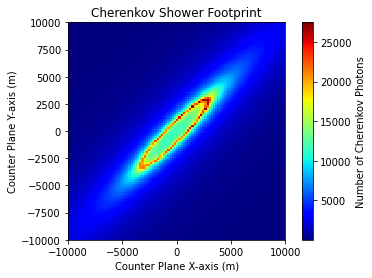

In [2]:
fig = plt.figure()
h2d = plt.hist2d(counters[:,0],counters[:,1],weights=sim.get_photon_sum(),bins=100, cmap=plt.cm.jet)
plt.title('Cherenkov Shower Footprint')
plt.xlabel('Counter Plane X-axis (m)')
plt.ylabel('Counter Plane Y-axis (m)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')

Now let's attenuate the signal. This attenuation is the flat-planar atmosphere approximation.

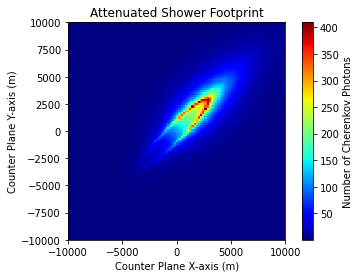

In [3]:
fig = plt.figure()
h2d = plt.hist2d(counters[:,0],counters[:,1],weights=sim.get_attenuated_photon_sum(),bins=100, cmap=plt.cm.jet)
plt.title('Attenuated Shower Footprint')
plt.xlabel('Counter Plane X-axis (m)')
plt.ylabel('Counter Plane Y-axis (m)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')

Now let's see the effect of having a curved atmosphere. This effectively shortens the path length of photons, meaning they are attenuated less.

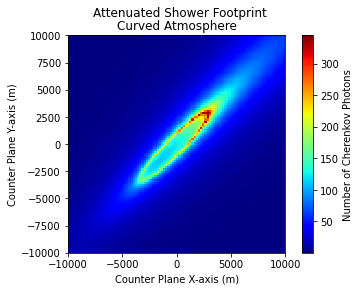

In [4]:
sim.run(curved = True)

fig = plt.figure()
h2d = plt.hist2d(counters[:,0],counters[:,1],weights=sim.get_attenuated_photon_sum(),bins=100, cmap=plt.cm.jet)
plt.suptitle('Attenuated Shower Footprint')
plt.title('Curved Atmosphere')
plt.xlabel('Counter Plane X-axis (m)')
plt.ylabel('Counter Plane Y-axis (m)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')